# Weighted average predictions
A prediction with expert advice is done considering
1. A decision space $\cal D$,
2. an outcome space $\cal y$,
3. A loss function $\ell$, and
4. a set of $\cal E$ of experts indices

For each round $t=1,2,\ldots$
1. The environment chooses the next outcome $y_t$ and the expert advice $\{f_{e,t} \in {\cal D}: e \in {\cal E}\}$;
2. The forecaster chooses the prediction $\hat{p}_t \in {\cal D}$;
3. The environmente reveals the next outcome $y_t \in {\cal Y}$;
4. the forecaster incurs loss $\ell(\hat p_t, y_t)$ and each expert $e$ incurs loss $\ell(f_{e,t}, y_t)$j

In [15]:
import jax
import numpy as np
import jax.numpy as jnp
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import partial

In [3]:
%config InlineBackend.figure_format = "retina"

### Regret
The forecaster's goal is to keep as small as possible cumulative regret. For expert $e$, this quantity is defined by

$$
    R_{e,T} = \sum_{t=1}^T\left(\ell(\hat p_t, y_t)  - \ell(f_{e, t}, y_t)\right) = \hat L_T - L_{e, T}.
$$


### The weighted average forecaster
(A forecaster based on the potential $\Phi$)  
Using the notion of potential function, we give the following definition of the weighted average forecaster

$$
    \hat p_t = \frac{\sum_{e=1}^E \nabla\Phi(R_{t-1})_e f_{e,t}}{\sum_{e=1}^E \nabla\Phi(R_{t-1})_e}
$$

### Polynomially-weighted average forecaster

We consider the polynomially-weighted average forecaster based on the potential

$$
    \Phi_p({\bf u}) = \left(\sum_{e=1}^E (u_e)_+^p\right)^{2/p} = ||{\bf u}||_{p}^2
$$

Although $\nabla\Phi_p$ is relatively straighforward to compute, we make use of `jax.grad` for simplicity.

In [4]:
def loss(yhat, y):
    return (yhat - y) ** 2

def potential(x, p):
    xhat = jnp.maximum(0, x)
    return jnp.linalg.norm(xhat, p) ** 2

@partial(jax.vmap, in_axes=(0, 0, None), out_axes=-1)
def create_mistakes(key, p, T):
    mistakes = jax.random.bernoulli(key, p=p, shape=(T,))
    return mistakes


gradp = jax.grad(potential)
vloss = jax.vmap(loss, in_axes=(0, None))

In [5]:
def forecast_step(experts_curr, regret_prev, pnorm):
    weights = gradp(regret_prev, pnorm)
    forecast = weights @ experts_curr / weights.sum()
    return forecast

def update_regret(forecast, experts, oracle, regret_prev):
    """
    Regret is cumulative
    """
    inst_regret = loss(forecast, oracle) - loss(experts, oracle)
    regret = regret_prev + inst_regret
    return regret

def step(regret, xs, pnorm):
    """
    At time t, we make a prediction based on the
    regret (as defined by the potential) obtained at time
    t-1 and the prediction of each forecaster at time t.

    After making a new prediction, we update the regret.
    """
    experts, oracle = xs
    forecast = forecast_step(experts, regret, pnorm)
    regret_new = update_regret(forecast, experts, oracle, regret)
    return regret_new, (forecast, regret_new)

## Evaluating the forecaster
### Creating *stream* of data

In this example, we consider an oracle that takes decisions according to $y_t \sim \text{Bern}(\mu)$. We consider `n_experts` number of experts.  Each expert is correct $v_e \sim \text{Beta}(a, b)$ proportion of times.

## Experts

In [6]:
key = jax.random.PRNGKey(314)

key_oracle, key_experts, key_noise, key_errs = jax.random.split(key, 4)

p_mistake = 0.1
n_experts = 20
n_timesteps = 5_000

oracle = jax.random.bernoulli(key_oracle, p=0.5, shape=(n_timesteps,))

keys_noise = jax.random.split(key_noise, n_experts)
ps_mistakes = jax.random.beta(key_errs, a=2, b=7, shape=(n_experts,))

mistakes = create_mistakes(keys_noise, ps_mistakes, n_timesteps)
experts = (mistakes ^ oracle[:, None]).astype(float)

In [7]:
regret = jnp.ones(n_experts)
xs = (experts, oracle)
part_step = partial(step, pnorm=2)
_, (forecast, regret_hist) = jax.lax.scan(part_step, regret, xs)

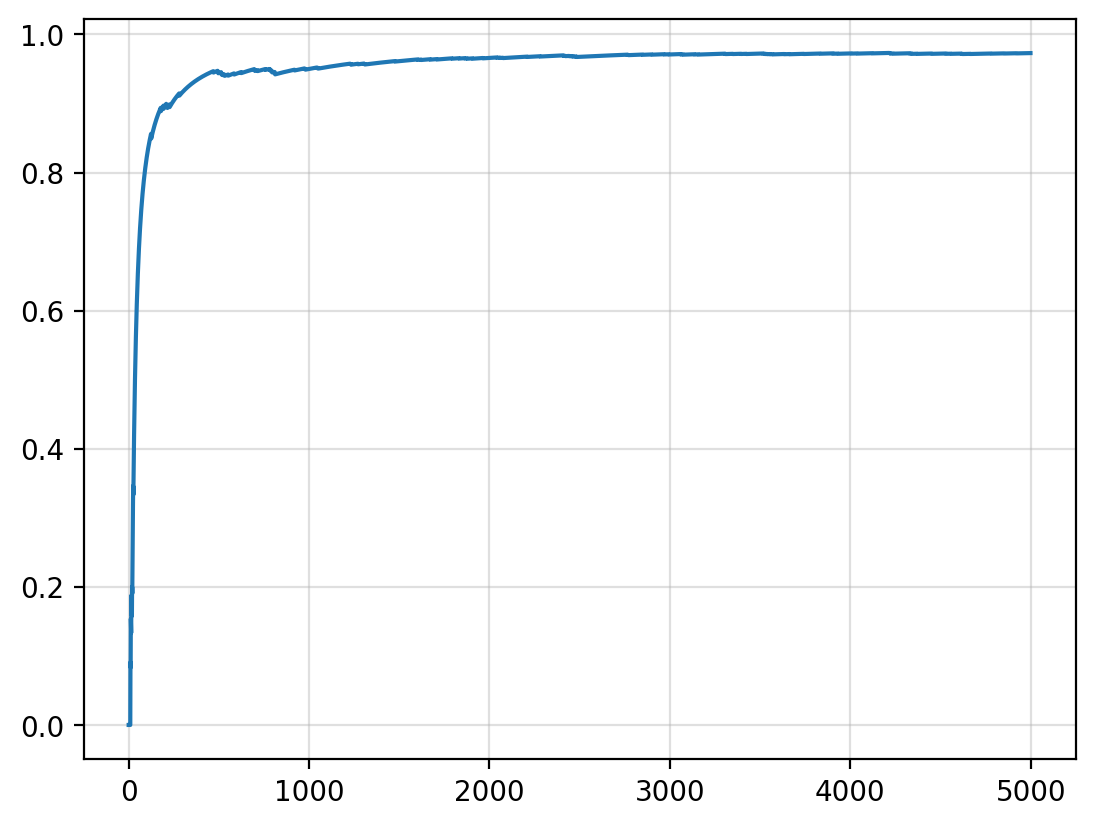

In [8]:
rolling_acc = (forecast == oracle).cumsum() / jnp.arange(1, n_timesteps + 1)
plt.plot(rolling_acc)
plt.grid(alpha=0.4)

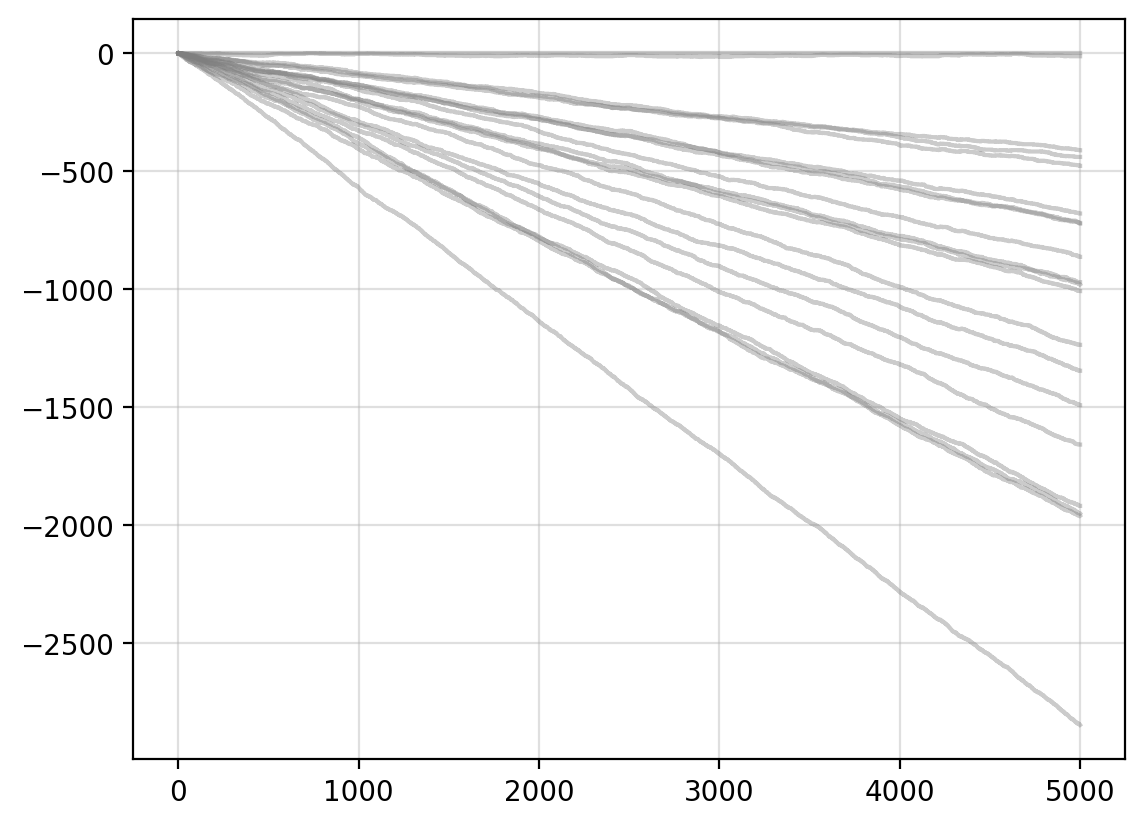

In [9]:
plt.plot(regret_hist, c="tab:gray", alpha=0.4)
plt.grid(alpha=0.4);

## Test 02: an HM process
In this example, each agent is correct with probability $v_e \sim \text{Beta}(a_t, b_t)$, where $a_t$ and $b_t$ are sampled from a hidden Markov process (HM)

In [10]:
import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions

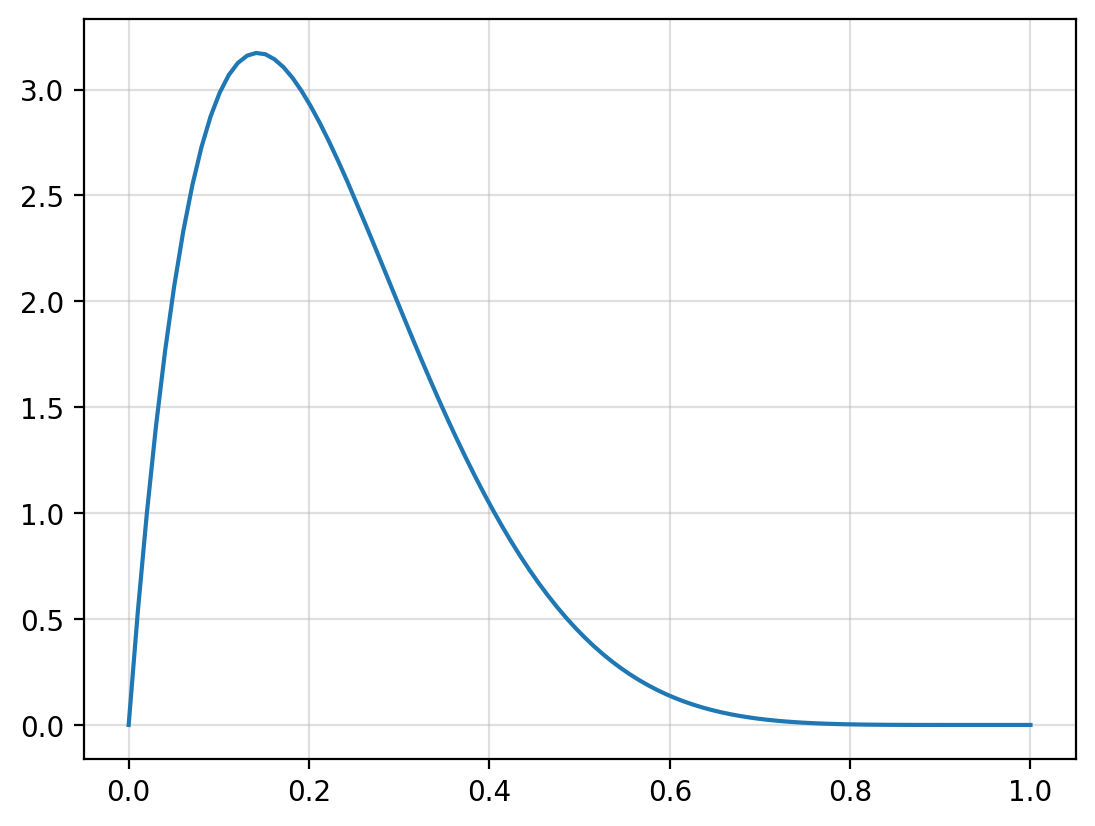

In [73]:
a, b = 2, 7
p_err = tfd.Beta(a, b)

x_err = jnp.linspace(0, 1, 100)
plt.plot(x_err, p_err.prob(x_err))
plt.grid(alpha=0.4)

In [74]:
key = jax.random.PRNGKey(314)


n_experts = 20
regimes = 15
n_timesteps_regime = 1_000
n_timesteps = regimes * n_timesteps_regime


# True oracle. Doesn't change
key_oracle, key_agent = jax.random.split(key)
oracle = jax.random.bernoulli(key_oracle, p=0.5, shape=(n_timesteps,))

mistakes = []
probas_mistakes = []
for i in range(regimes):
    keyi = jax.random.fold_in(key_agent, i)
    key_experts, key_noise, key_errs = jax.random.split(keyi, 3)
    keys_noise = jax.random.split(key_noise, n_experts)

    # Probability of a possible mistake
    ps_mistakes = jax.random.beta(key_errs, a=a, b=b, shape=(n_experts,))
    mistakes_regime = create_mistakes(keys_noise, ps_mistakes, n_timesteps_regime)
    probas_mistakes.append(ps_mistakes)
    mistakes.append(mistakes_regime)

probas_mistakes = jnp.stack(probas_mistakes, axis=0)
mistakes = jnp.concatenate(mistakes, axis=0)
experts = (mistakes ^ oracle[:, None]).astype(float)

In [75]:
%%time
regret = jnp.ones(n_experts)
xs = (experts, oracle)
part_step = partial(step, pnorm=2)
_, (forecast, regret_hist) = jax.lax.scan(part_step, regret, xs)
forecast = jax.tree_map(np.array, forecast)

CPU times: user 424 ms, sys: 20.6 ms, total: 445 ms
Wall time: 445 ms


Text(0.5, 1.0, 'Overall accuracy')

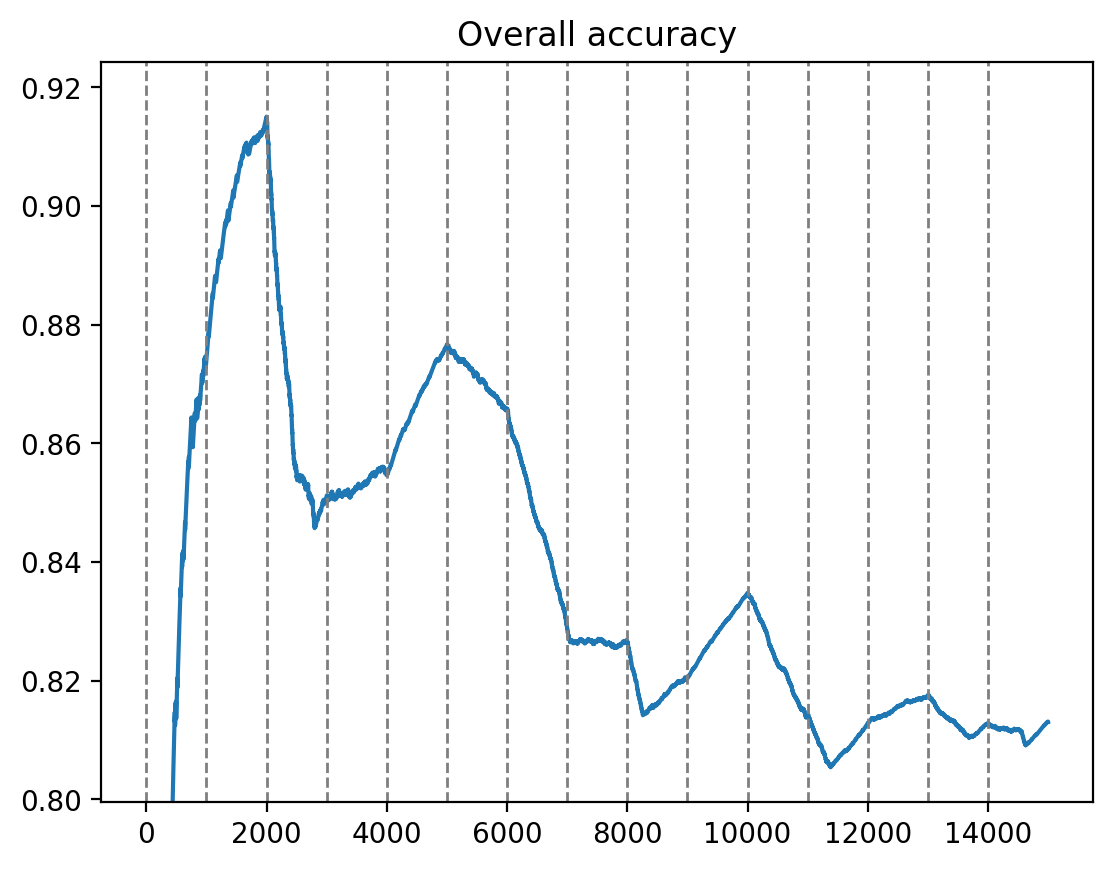

In [76]:
rolling_acc = (forecast == oracle).cumsum() / jnp.arange(1, n_timesteps + 1)
plt.plot(rolling_acc)
for i in range(regimes):
    plt.axvline(i * n_timesteps_regime, c="tab:gray", linewidth=1, linestyle="--")
# plt.grid(alpha=0.4)
vmin = jnp.quantile(rolling_acc, 0.05) * 0.99
vmax = jnp.quantile(rolling_acc, 1.0) * 1.01
plt.ylim(vmin, vmax)
plt.title("Overall accuracy")

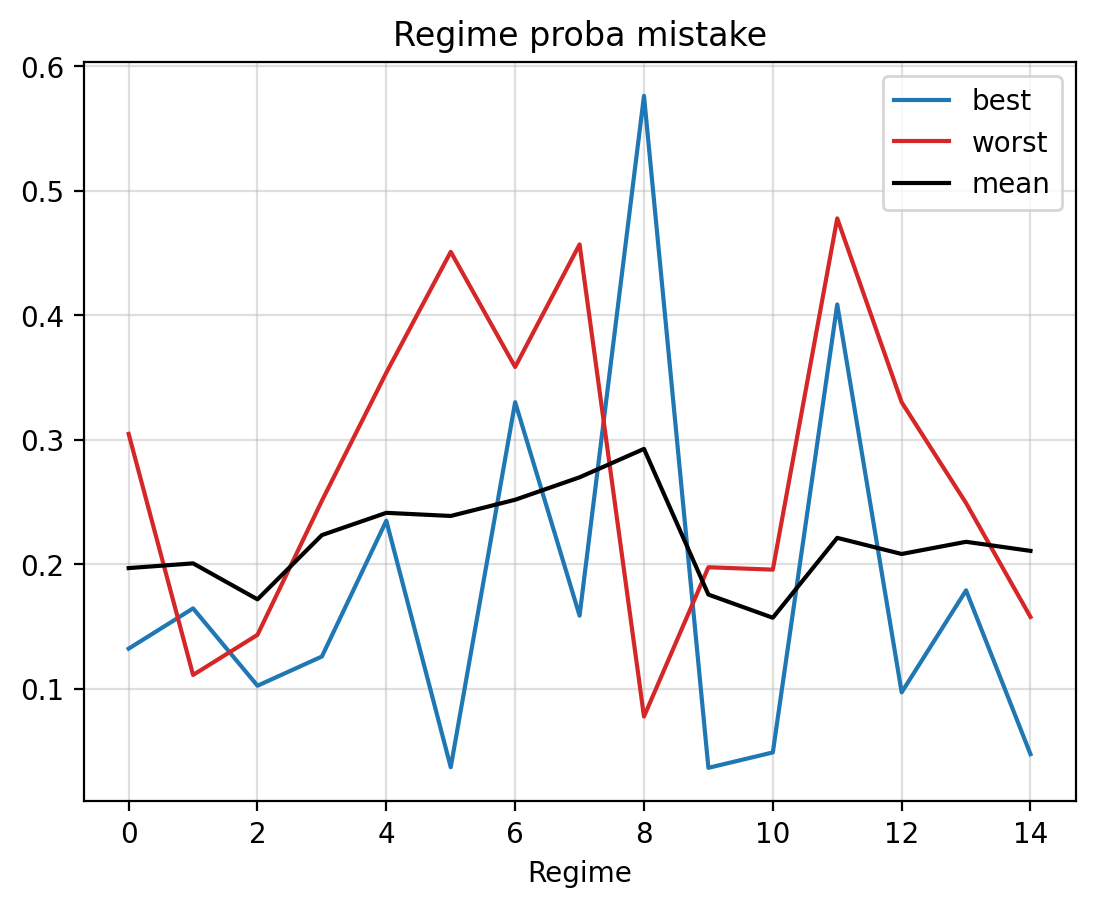

In [77]:
best_agent = regret_hist[-1].argmax()
worst_agent = regret_hist[-1].argmin()

plt.plot(probas_mistakes[:, best_agent], c="tab:blue", label="best")
plt.plot(probas_mistakes[:, worst_agent], c="tab:red", label="worst")
plt.plot(probas_mistakes.mean(axis=1), c="black", label="mean")
plt.title("Regime proba mistake")
plt.xlabel("Regime")
plt.legend()
plt.grid(alpha=0.4)

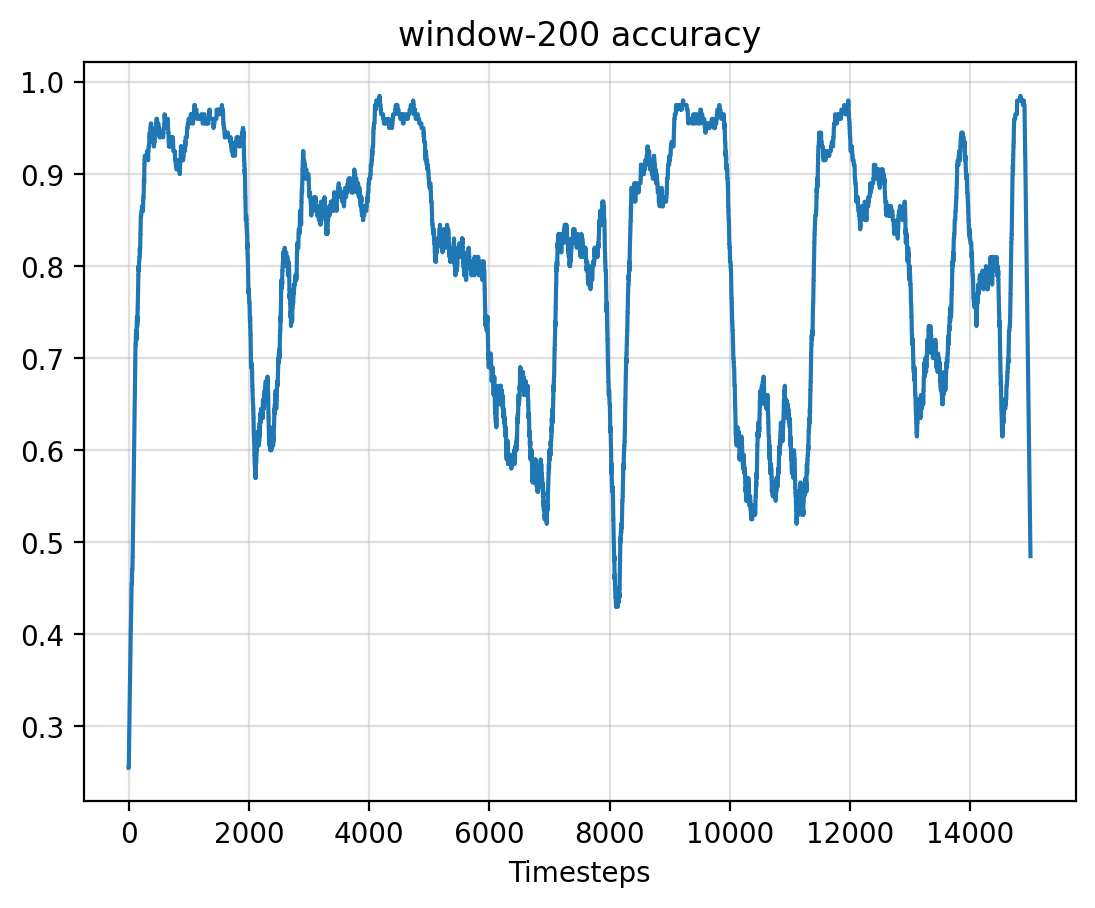

In [78]:
window_size = 200
window = np.ones(window_size) / window_size
evals = np.array(forecast == oracle)

window_acc = np.convolve(evals, window, mode="same")
plt.plot(window_acc)
plt.title(f"window-{window_size} accuracy")
plt.xlabel("Timesteps")
plt.grid(alpha=0.4)

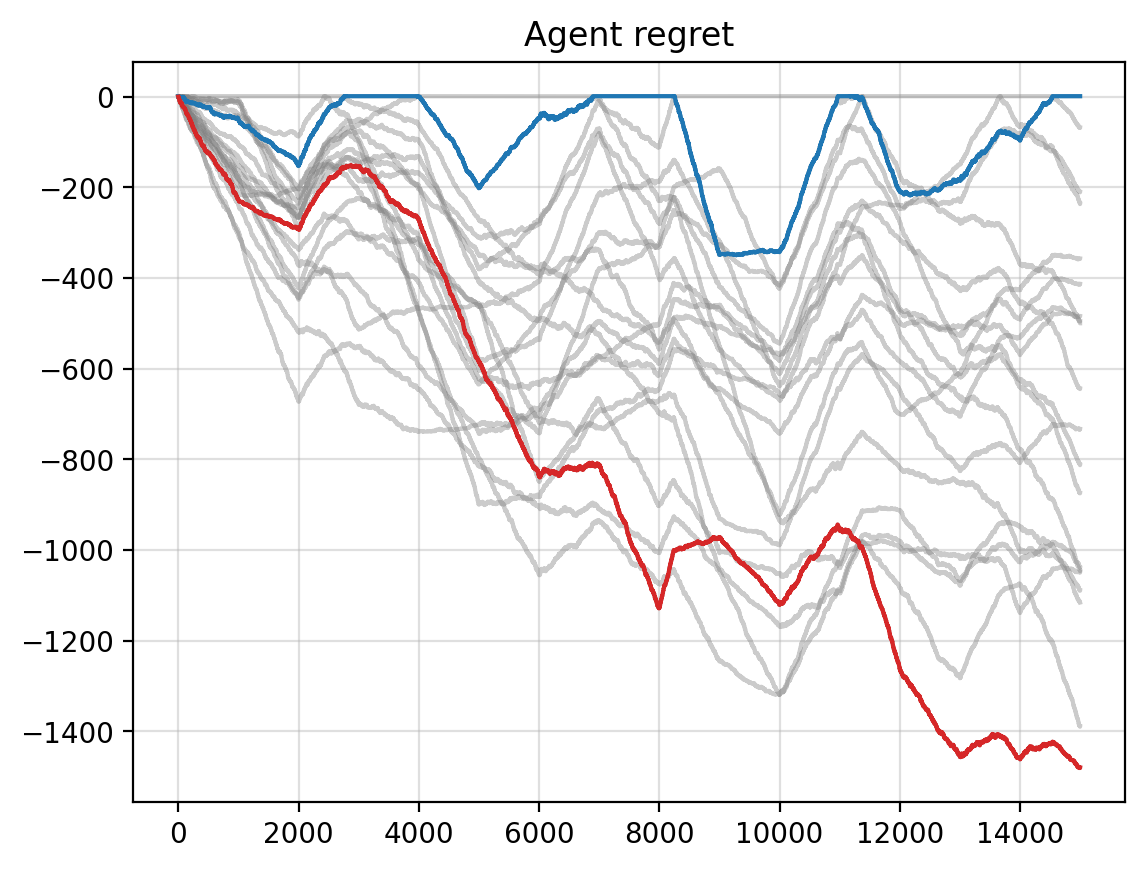

In [79]:
plt.plot(regret_hist, c="tab:gray", alpha=0.4)
plt.plot(regret_hist[:, best_agent], c="tab:blue")
plt.plot(regret_hist[:, worst_agent], c="tab:red")
plt.title("Agent regret")
plt.grid(alpha=0.4);